# Setup

In [1]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np
from scipy.linalg import block_diag

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from GEModel import GEModelClass

In [2]:
model = GEModelClass('baseline')
print(model)

Modelclass: GEModelClass

Parameters:
 sigma = 2.0 [float64]
 beta = 0.96 [float64]
 r = 0.03 [float64]
 w = 1.0 [float64]
 rho = 0.97 [float64]
 sigma_e = 0.25 [float64]
 Ne = 7 [int64]
 a_max = 200.0 [float64]
 Na = 500 [int64]
 simN = 1000000 [int64]
 max_iter_solve = 5000 [int64]
 max_iter_simulate = 5000 [int64]
 solve_tol = 1e-08 [float64]
 simulate_tol = 0.0001 [float64]
 a_grid = array(float64, 1d, C) with shape = (500,)
 e_grid = array(float64, 1d, C) with shape = (7,)
 e_trans = array(float64, 2d, C) with shape = (7, 7)
 e_ergodic = array(float64, 1d, C) with shape = (7,)
 e_trans_cumsum = array(float64, 2d, C) with shape = (7, 7)
 e_ergodic_cumsum = array(float64, 1d, C) with shape = (7,)
memory, gb: 0.0

Solution:
 a = array(float64, 2d, C) with shape = (7, 500)
 m = array(float64, 2d, C) with shape = (7, 500)
 c = array(float64, 2d, C) with shape = (7, 500)
 V = array(float64, 2d, C) with shape = (7, 500)
 Va = array(float64, 2d, C) with shape = (7, 500)
 Vbar = array(floa

**Productivity states:**

In [3]:
par = model.par
sol = model.sol
sim = model.sim

for e,pr_e in zip(par.e_grid,par.e_ergodic):
    print(f'Pr[e = {e:.4f}] = {pr_e:.4f}')
    
assert np.isclose(np.sum(par.e_grid*par.e_ergodic),1.0)

Pr[e = 0.5254] = 0.0156
Pr[e = 0.6444] = 0.0938
Pr[e = 0.7903] = 0.2344
Pr[e = 0.9693] = 0.3125
Pr[e = 1.1888] = 0.2344
Pr[e = 1.4580] = 0.0938
Pr[e = 1.7881] = 0.0156


# Solve

In [4]:
model.solve(do_print=True)

household problem solved in 4.3 secs [432 iterations]
[value function abs. max diff. is 0.00000001]


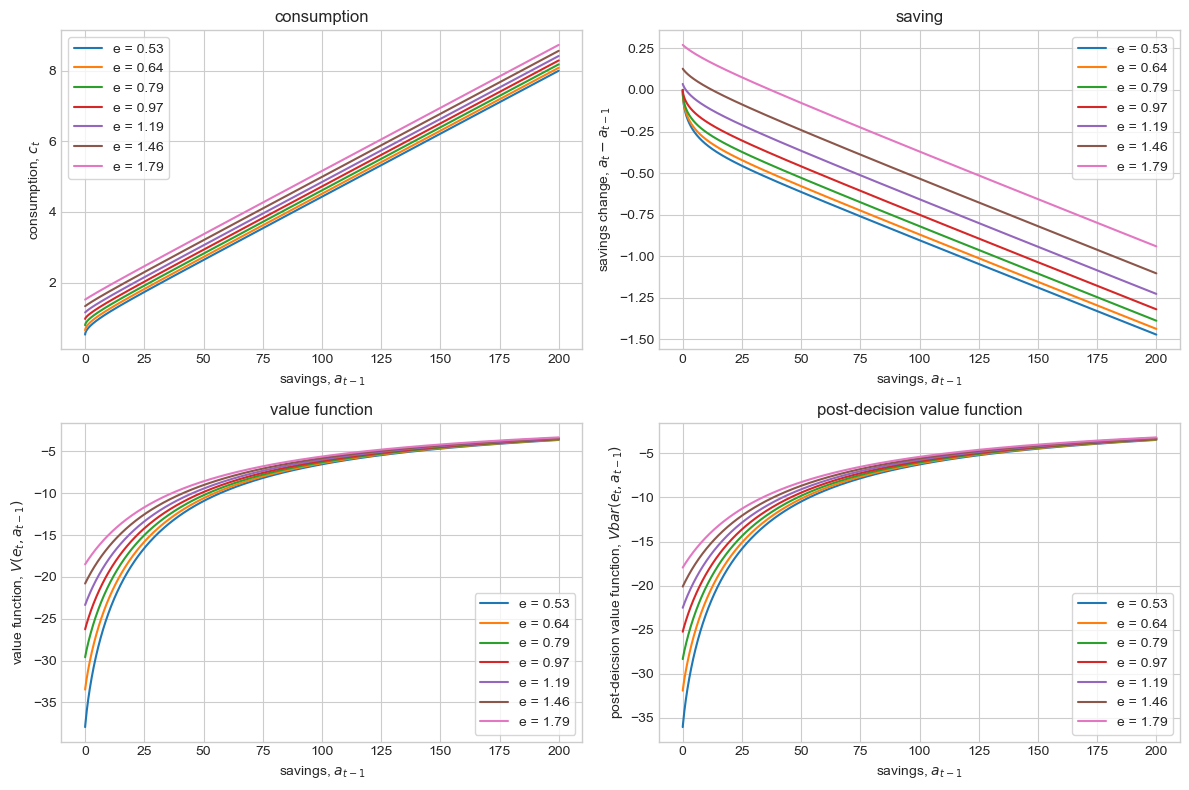

In [5]:
fig = plt.figure(figsize=(12,8),dpi=100)

# a. consumption
ax = fig.add_subplot(2,2,1)
ax.set_title('consumption')

for i_e,e in enumerate(par.e_grid):
    ax.plot(par.a_grid,sol.c[i_e,:],label=f'e = {e:.2f}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')

# b. saving
ax = fig.add_subplot(2,2,2)
ax.set_title('saving')

for i_e,e in enumerate(par.e_grid):
    ax.plot(par.a_grid,sol.a[i_e,:]-par.a_grid,label=f'e = {e:.2f}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings change, $a_{t}-a_{t-1}$')

# c. value function
ax = fig.add_subplot(2,2,3)
ax.set_title('value function')

for i_e,e in enumerate(par.e_grid):
    ax.plot(par.a_grid,sol.V[i_e],label=f'e = {e:.2f}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('value function, $V(e_t,a_{t-1})$')

# c. post-decision value function
ax = fig.add_subplot(2,2,4)
ax.set_title('post-decision value function')

for i_e,e in enumerate(par.e_grid):
    ax.plot(par.a_grid,sol.Vbar[i_e],label=f'e = {e:.2f}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('post-deicsion value function, $Vbar(e_t,a_{t-1})$')


fig.tight_layout()

# Test of matrix-form

**Define matrices:**

In [6]:
# a. allocate Q
Q = np.zeros((par.Ne*par.Na,par.Ne*par.Na))

# b. fill
for i_e in range(par.Ne):
    
    # get view of current block
    q = Q[i_e*par.Na:(i_e+1)*par.Na,i_e*par.Na:(i_e+1)*par.Na]
    
    for i_a in range(par.Na):
        
        # i. optimal choice
        a_opt = sol.a[i_e,i_a]
        
        # ii. above -> all weight on last node
        if a_opt >= par.a_grid[-1]:
            
            q[i_a,-1] = 1.0 
        
        # iii. below -> all weight on first node
        elif a_opt <= par.a_grid[0]:
            
            q[i_a,0] = 1.0
        
        # iv. standard -> distribute weights on neighboring nodes
        else:   
            
            i_a_low = np.searchsorted(par.a_grid,a_opt,side='right')-1      
            
            assert a_opt >= par.a_grid[i_a_low], f'{a_opt} < {par.a_grid[i_a_low]}'
            assert a_opt < par.a_grid[i_a_low+1], f'{a_opt} < {par.a_grid[i_a_low]}'
            
            q[i_a,i_a_low] = (par.a_grid[i_a_low+1]-a_opt)/(par.a_grid[i_a_low+1]-par.a_grid[i_a_low])
            q[i_a,i_a_low+1] = 1-q[i_a,i_a_low]
            
# c. calculate Pit
Pit = np.kron(par.e_trans, np.identity(par.Na))

**Calculate $\Omega$**

In [7]:
Omega = Q@Pit

**Test:**

In [8]:
v_vec = np.reshape(sol.V,(par.Ne*par.Na,1))
c_vec = np.reshape(sol.c,(par.Ne*par.Na,1))
vbar_vec = np.reshape(sol.Vbar,(par.Ne*par.Na,1))
u_vec = c_vec**(1-par.sigma)/(1-par.sigma)
v_vec_next = u_vec + par.beta*Omega@v_vec
max_abs_diff = np.max(np.abs(v_vec-v_vec_next))
print(f'We should max_abs_diff = 0.0')
print(f'We have max_abs_diff   = {max_abs_diff:.8f}')

We should max_abs_diff = 0.0
We have max_abs_diff   = 0.00000001


# Simulate

## Standard simulation method

In [9]:
model.simulate(do_print=True)

household problem simulated in 21.5 secs [221 iterations]


## Alternative simulation methods

In [10]:
from scipy.linalg import svd

def find_ergodic(trans,atol=1e-13,rtol=0):
    """ find ergodic distribution from transition matrix 
    
    Args:

        trans (numpy.ndarray): transition matrix
        atol (double): absolute tolerance
        rtol (double): relative tolerance
    
    Returns:

        (nump.ndarray): ergodic distribution

    """

    I = np.identity(len(trans))
    A = np.atleast_2d(np.transpose(trans)-I)
    _u, s, vh = svd(A)
    tol = max(atol, rtol * s[0])
    nnz = (s >= tol).sum()
    ns = vh[nnz:].conj().T

    return (ns/(sum(ns))).ravel()

**Transition matrix:**

In [11]:
OmegaT = Omega.T

**Method I**

In [12]:
D_I = find_ergodic(OmegaT)
D_I = D_I.reshape((par.Ne,par.Na))

**Method II:**

In [13]:
# a. initial distribution
D = np.zeros((par.Ne,par.Na))
D[:,0] = par.e_ergodic # start from zero assets
D = np.ravel(D)

# b. preparation


tol = 1e-8
max_iter = 1000
it = 0
do_print = True

# c. simulate
while True:
    
    # a. old
    D_old = D.copy()
    
    # b. update
    D = OmegaT@D
    
    # c. diff
    diff_max_abs = np.max(np.abs(D-D_old))
    
    if do_print and it%50 == 0:
        print(f'it = {it:3d} -> diff_max_abs {diff_max_abs:12.8f} [sum(D) = {np.sum(D):.4f}]')
    
    if diff_max_abs < tol or it > max_iter:
        break
    
    it += 1
    
# d. reshape
D_II = D.reshape((par.Ne,par.Na))

it =   0 -> diff_max_abs   0.22102597 [sum(D) = 1.0000]
it =  50 -> diff_max_abs   0.00046957 [sum(D) = 1.0000]
it = 100 -> diff_max_abs   0.00010862 [sum(D) = 1.0000]
it = 150 -> diff_max_abs   0.00003085 [sum(D) = 1.0000]
it = 200 -> diff_max_abs   0.00000901 [sum(D) = 1.0000]
it = 250 -> diff_max_abs   0.00000264 [sum(D) = 1.0000]
it = 300 -> diff_max_abs   0.00000078 [sum(D) = 1.0000]
it = 350 -> diff_max_abs   0.00000023 [sum(D) = 1.0000]
it = 400 -> diff_max_abs   0.00000007 [sum(D) = 1.0000]
it = 450 -> diff_max_abs   0.00000002 [sum(D) = 1.0000]


## Illustration

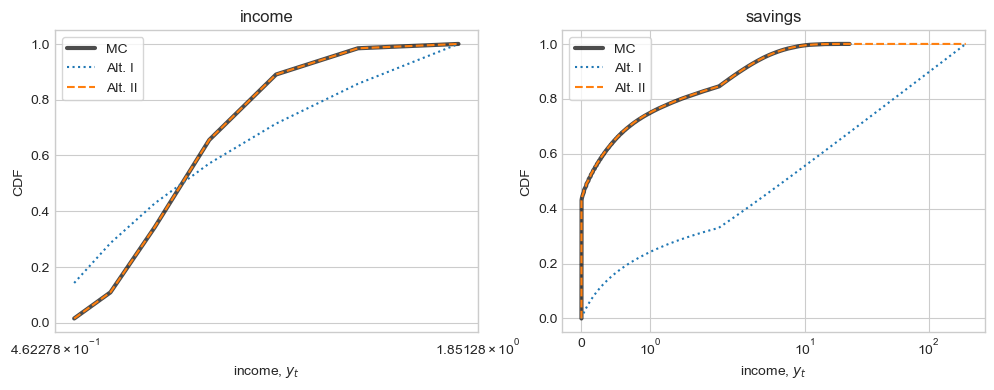

In [14]:
fig = plt.figure(figsize=(12,4),dpi=100)

# a. income
ax = fig.add_subplot(1,2,1)
ax.set_title('income')
ax.plot(par.e_grid,np.cumsum([np.mean(sim.y == e) for e in par.e_grid]),lw=3,alpha=0.7,color='black',label='MC')
ax.plot(par.e_grid,np.cumsum(np.sum(D_I,axis=1)),ls=':',label='Alt. I')
ax.plot(par.e_grid,np.cumsum(np.sum(D_II,axis=1)),ls='--',label='Alt. II')
ax.set_xlabel('income, $y_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')
ax.legend(frameon=True)

# b. assets
ax = fig.add_subplot(1,2,2)
ax.set_title('savings')
ax.plot(np.sort(sim.a),np.arange(par.simN)/par.simN,lw=3,alpha=0.7,color='black',label='MC')
ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),np.insert(np.cumsum(np.sum(D_I,axis=0)),0,0.0),ls=':',label='Alt. I')
ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),np.insert(np.cumsum(np.sum(D_II,axis=0)),0,0.0),ls='--',label='Alt. II')
ax.set_xlabel('income, $y_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')
ax.legend(frameon=True)

In [15]:
print(f'mean y: {np.mean(sim.y):.2f}')
print(f'std. y: {np.std(sim.y):.2f}')

mean y: 1.00
std. y: 0.25


In [16]:
print(f'mean a: {np.mean(sim.a):.2f}')
print(f'std. a: {np.std(sim.a):.2f}')

mean a: 0.92
std. a: 1.77


## Test `find_ergodic`

In [17]:
e_ergodic = find_ergodic(par.e_trans)

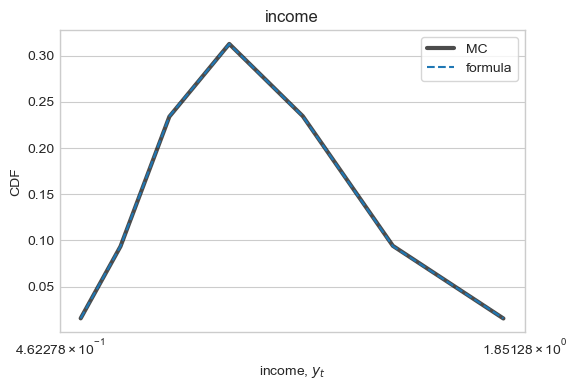

In [18]:
fig = plt.figure(figsize=(6,4),dpi=100)

ax = fig.add_subplot(1,1,1)
ax.set_title('income')
ax.plot(par.e_grid,[np.mean(sim.y == e) for e in par.e_grid],lw=3,alpha=0.7,color='black',label='MC')
ax.plot(par.e_grid,e_ergodic,label='formula',ls='--')
ax.set_xlabel('income, $y_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')
ax.legend(frameon=True)
